<a href="https://colab.research.google.com/github/leonsuarez24/Notebooks/blob/main/Dataset_Condensation_With_Distribution_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import copy
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.ndimage.interpolation import rotate as scipyrotate

<ipython-input-1-dfffe990ca36>:12: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate as scipyrotate


# Utils

In [2]:
def get_time():
    return str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))

In [3]:
class ParamDiffAug():
    def __init__(self):
        self.aug_mode = 'S' #'multiple or single'
        self.prob_flip = 0.5
        self.ratio_scale = 1.2
        self.ratio_rotate = 15.0
        self.ratio_crop_pad = 0.125
        self.ratio_cutout = 0.5 # the size would be 0.5x0.5
        self.brightness = 1.0
        self.saturation = 2.0
        self.contrast = 0.5


def set_seed_DiffAug(param):
    if param.latestseed == -1:
        return
    else:
        torch.random.manual_seed(param.latestseed)
        param.latestseed += 1


def DiffAugment(x, strategy='', seed = -1, param = None):
    '''
       x     -> images
    stragegy -> color_crop_cutout_flip_scale_rotate (default)
      seed   -> int(time.time() * 1000) % 100000 (default)
      param  -> args.dsa_param = ParamDiffAug()  ->   self.aug_mode = 'S' #'multiple or single'
                                                      self.prob_flip = 0.5
                                                      self.ratio_scale = 1.2
                                                      self.ratio_rotate = 15.0
                                                      self.ratio_crop_pad = 0.125
                                                      self.ratio_cutout = 0.5 # the size would be 0.5x0.5
                                                      self.brightness = 1.0
                                                      self.saturation = 2.0
                                                      self.contrast = 0.5
    '''
    if strategy == 'None' or strategy == 'none' or strategy == '':
        return x

    if seed == -1:
        param.Siamese = False
    else:
        param.Siamese = True

    param.latestseed = seed

    if strategy:
        if param.aug_mode == 'M': # original
            for p in strategy.split('_'):
                for f in AUGMENT_FNS[p]:
                    x = f(x, param)
        elif param.aug_mode == 'S':
            pbties = strategy.split('_')
            set_seed_DiffAug(param)
            p = pbties[torch.randint(0, len(pbties), size=(1,)).item()]
            for f in AUGMENT_FNS[p]:
                x = f(x, param)
        else:
            exit('unknown augmentation mode: %s'%param.aug_mode)
        x = x.contiguous()
    return x

# We implement the following differentiable augmentation strategies based on the code provided in https://github.com/mit-han-lab/data-efficient-gans.
def rand_scale(x, param):
    # x>1, max scale
    # sx, sy: (0, +oo), 1: orignial size, 0.5: enlarge 2 times
    ratio = param.ratio_scale
    set_seed_DiffAug(param)
    sx = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    set_seed_DiffAug(param)
    sy = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    theta = [[[sx[i], 0,  0],
            [0,  sy[i], 0],] for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_rotate(x, param): # [-180, 180], 90: anticlockwise 90 degree
    ratio = param.ratio_rotate
    set_seed_DiffAug(param)
    theta = (torch.rand(x.shape[0]) - 0.5) * 2 * ratio / 180 * float(np.pi)
    theta = [[[torch.cos(theta[i]), torch.sin(-theta[i]), 0],
        [torch.sin(theta[i]), torch.cos(theta[i]),  0],]  for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_flip(x, param):
    prob = param.prob_flip
    set_seed_DiffAug(param)
    randf = torch.rand(x.size(0), 1, 1, 1, device=x.device)
    if param.Siamese: # Siamese augmentation:
        randf[:] = randf[0]
    return torch.where(randf < prob, x.flip(3), x)


def rand_brightness(x, param):
    ratio = param.brightness
    set_seed_DiffAug(param)
    randb = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randb[:] = randb[0]
    x = x + (randb - 0.5)*ratio
    return x


def rand_saturation(x, param):
    ratio = param.saturation
    x_mean = x.mean(dim=1, keepdim=True)
    set_seed_DiffAug(param)
    rands = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        rands[:] = rands[0]
    x = (x - x_mean) * (rands * ratio) + x_mean
    return x


def rand_contrast(x, param):
    ratio = param.contrast
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    set_seed_DiffAug(param)
    randc = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randc[:] = randc[0]
    x = (x - x_mean) * (randc + ratio) + x_mean
    return x


def rand_crop(x, param):
    # The image is padded on its surrounding and then cropped.
    ratio = param.ratio_crop_pad
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        translation_x[:] = translation_x[0]
        translation_y[:] = translation_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, param):
    ratio = param.ratio_cutout
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        offset_x[:] = offset_x[0]
        offset_y[:] = offset_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x

# Augment Functions
AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'crop': [rand_crop],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
    'scale': [rand_scale],
    'rotate': [rand_rotate],
}

In [4]:
def epoch(mode, dataloader, net, optimizer, criterion, args, aug):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(args.device)
    criterion = criterion.to(args.device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(args.device)
        if aug:
            if args.dsa:
                img = DiffAugment(img, args.dsa_strategy, param=args.dsa_param)

        lab = datum[1].long().to(args.device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [5]:
def evaluate_synset(it_eval, net, images_train, labels_train, testloader, args):
    net = net.to(args.device)
    images_train = images_train.to(args.device)
    labels_train = labels_train.to(args.device)
    lr = float(args.lr_net)
    Epoch = int(args.epoch_eval_train)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(args.device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=args.batch_train, shuffle=True, num_workers=0)

    start = time.time()
    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, args, aug = True)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    time_train = time.time() - start
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, args, aug = False)
    print('%s Evaluate_%02d: epoch = %04d train time = %d s train loss = %.6f train acc = %.4f, test acc = %.4f' % (get_time(), it_eval, Epoch, int(time_train), loss_train, acc_train, acc_test))

    return net, acc_train, acc_test

# Network

In [6]:
''' Swish activation '''
class Swish(nn.Module): # Swish(x) = x∗σ(x)
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.sigmoid(input)

In [7]:
''' ConvNet '''
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size = (32,32)):
        super(ConvNet, self).__init__()

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return out

    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid()
        elif net_act == 'relu':
            return nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif net_act == 'swish':
            return Swish()
        else:
            exit('unknown activation function: %s'%net_act)

    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            return None
        else:
            exit('unknown net_pooling: %s'%net_pooling)

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s'%net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat

In [8]:
def get_default_convnet_setting():
    net_width, net_depth, net_act, net_norm, net_pooling = 128, 3, 'relu', 'instancenorm', 'avgpooling'
    return net_width, net_depth, net_act, net_norm, net_pooling

In [9]:
def get_network(model, channel, num_classes, im_size=(32, 32)):
    torch.random.manual_seed(int(time.time() * 1000) % 100000)
    net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()

    net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    return net

# Dataset

In [10]:
def get_dataset(dataset, data_path):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'SVHN':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4377, 0.4438, 0.4728]
        std = [0.1980, 0.2010, 0.1970]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.SVHN(data_path, split='train', download=True, transform=transform)  # no augmentation
        dst_test = datasets.SVHN(data_path, split='test', download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'CIFAR100':
        channel = 3
        im_size = (32, 32)
        num_classes = 100
        mean = [0.5071, 0.4866, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR100(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR100(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'TinyImageNet':
        channel = 3
        im_size = (64, 64)
        num_classes = 200
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        data = torch.load(os.path.join(data_path, 'tinyimagenet.pt'), map_location='cpu')

        class_names = data['classes']

        images_train = data['images_train']
        labels_train = data['labels_train']
        images_train = images_train.detach().float() / 255.0
        labels_train = labels_train.detach()
        for c in range(channel):
            images_train[:,c] = (images_train[:,c] - mean[c])/std[c]
        dst_train = TensorDataset(images_train, labels_train)  # no augmentation

        images_val = data['images_val']
        labels_val = data['labels_val']
        images_val = images_val.detach().float() / 255.0
        labels_val = labels_val.detach()

        for c in range(channel):
            images_val[:, c] = (images_val[:, c] - mean[c]) / std[c]

        dst_test = TensorDataset(images_val, labels_val)  # no augmentation

    else:
        exit('unknown dataset: %s'%dataset)


    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=0)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader

In [11]:
class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

# Parameters

In [12]:
class Args():
    def __init__(self):
        self.dataset = 'CIFAR10'
        self.model = 'ConvNet'
        self.ipc = 50
        self.num_exp = 5
        self.epoch_eval_train = 1000
        self.Iteration = 20000
        self.lr_img = 1.0
        self.lr_net = 0.01
        self.batch_real = 256
        self.batch_train = 256
        self.init = 'noise'
        self.dsa_strategy = 'color_crop_cutout_flip_scale_rotate'
        self.data_path = 'data'
        self.dis_metric = 'ours'

args = Args()

# Training

In [13]:
args.method = 'DM'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = False if args.dsa_strategy in ['none', 'None'] else True

if not os.path.exists(args.data_path):
    os.mkdir(args.data_path)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(args.dataset, args.data_path)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args.ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args.device)
label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args.init == 'real':
    print('initialize synthetic data from random real images')
    for c in range(num_classes):
        image_syn.data[c*args.ipc:(c+1)*args.ipc] = get_images(c, args.ipc).detach().data
else:
    print('initialize synthetic data from random noise')

''' training '''
optimizer_img = torch.optim.SGD([image_syn, ], lr=args.lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img.zero_grad()
print('%s training begins'%get_time())

100%|██████████| 170498071/170498071 [00:12<00:00, 13142219.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
class c = 0: 5000 real images
class c = 1: 5000 real images
class c = 2: 5000 real images
class c = 3: 5000 real images
class c = 4: 5000 real images
class c = 5: 5000 real images
class c = 6: 5000 real images
class c = 7: 5000 real images
class c = 8: 5000 real images
class c = 9: 5000 real images
initialize synthetic data from random noise
[2023-07-31 20:14:55] training begins


<ipython-input-13-3433af3a68bc>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [14]:
for it in range(args.Iteration+1):
    ''' Train synthetic data '''
    net = get_network(args.model, channel, num_classes, im_size).to(args.device) # get a random model
    net.train()
    for param in list(net.parameters()):
        param.requires_grad = False

    embed = net.module.embed if torch.cuda.device_count() > 1 else net.embed # for GPU parallel

    loss_avg = 0

    ''' update synthetic data '''
    if 'BN' not in args.model: # for ConvNet
        loss = torch.tensor(0.0).to(args.device)
        for c in range(num_classes):
            img_real = get_images(c, args.batch_real)
            img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))

            if args.dsa:
                seed = int(time.time() * 1000) % 100000
                img_real = DiffAugment(img_real, args.dsa_strategy, seed=seed, param=args.dsa_param)
                img_syn = DiffAugment(img_syn, args.dsa_strategy, seed=seed, param=args.dsa_param)

            output_real = embed(img_real).detach()
            output_syn = embed(img_syn)

            loss += torch.sum((torch.mean(output_real, dim=0) - torch.mean(output_syn, dim=0))**2)

    else: # for ConvNetBN
        images_real_all = []
        images_syn_all = []
        loss = torch.tensor(0.0).to(args.device)
        for c in range(num_classes):
            img_real = get_images(c, args.batch_real)
            img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))

            if args.dsa:
                seed = int(time.time() * 1000) % 100000
                img_real = DiffAugment(img_real, args.dsa_strategy, seed=seed, param=args.dsa_param)
                img_syn = DiffAugment(img_syn, args.dsa_strategy, seed=seed, param=args.dsa_param)

            images_real_all.append(img_real)
            images_syn_all.append(img_syn)

        images_real_all = torch.cat(images_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)

        output_real = embed(images_real_all).detach()
        output_syn = embed(images_syn_all)

        loss += torch.sum((torch.mean(output_real.reshape(num_classes, args.batch_real, -1), dim=1) - torch.mean(output_syn.reshape(num_classes, args.ipc, -1), dim=1))**2)

    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()

    loss_avg /= (num_classes)

    if it%10 == 0:
        print('%s iter = %05d, loss = %.4f' % (get_time(), it, loss_avg))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[2023-07-31 20:15:02] iter = 00000, loss = 36.9681
[2023-07-31 20:15:04] iter = 00010, loss = 44.0319
[2023-07-31 20:15:06] iter = 00020, loss = 36.9289
[2023-07-31 20:15:08] iter = 00030, loss = 37.6362
[2023-07-31 20:15:10] iter = 00040, loss = 26.2448
[2023-07-31 20:15:12] iter = 00050, loss = 37.8043
[2023-07-31 20:15:14] iter = 00060, loss = 20.7144
[2023-07-31 20:15:16] iter = 00070, loss = 33.5436
[2023-07-31 20:15:18] iter = 00080, loss = 27.0328
[2023-07-31 20:15:20] iter = 00090, loss = 33.6363
[2023-07-31 20:15:22] iter = 00100, loss = 28.6825
[2023-07-31 20:15:24] iter = 00110, loss = 21.3415
[2023-07-31 20:15:26] iter = 00120, loss = 35.9009
[2023-07-31 20:15:28] iter = 00130, loss = 26.8024
[2023-07-31 20:15:30] iter = 00140, loss = 27.6400
[2023-07-31 20:15:32] iter = 00150, loss = 20.5789
[2023-07-31 20:15:34] iter = 00160, loss = 19.8131
[2023-07-31 20:15:36] iter = 00170, loss = 30.2278
[2023-07-31 20:15:38] iter = 00180, loss = 21.8971
[2023-07-31 20:15:40] iter = 00

In [15]:
import matplotlib.pyplot as plt
images_print, labels_print = copy.deepcopy(image_syn.detach()).cpu().detach().numpy(), copy.deepcopy(label_syn.detach()).cpu().detach().numpy()
images_print = images_print.transpose(0,2,3,1)

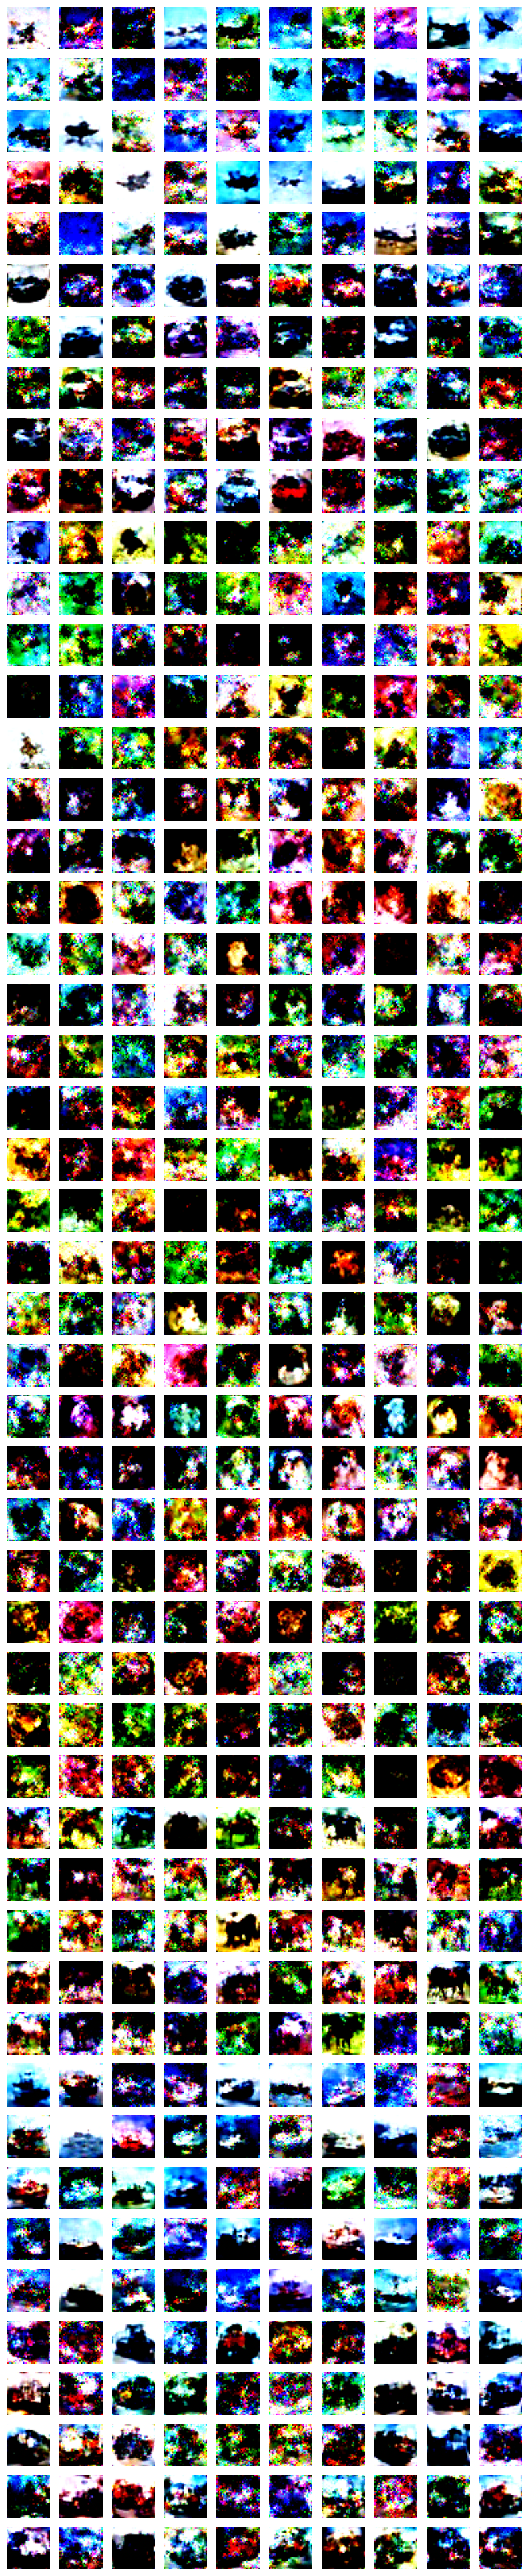

In [16]:
def print_syn_img():
    fig, axes = plt.subplots(args.ipc,num_classes, figsize=(10, 50))

    axes = axes.ravel()
    for i in range(args.ipc*num_classes):
        axes[i].imshow(images_print[i])
        axes[i].axis('off')

print_syn_img()